## Viewing and exploring overlapping labels

In this notebook we use the ```napari-segment-everything``` widget to view overlapping labels. 

This plugin is available on the [napari-hub](https://www.napari-hub.org/plugins/napari-segment-everything) and can be run without code.  However in this example we show all the code used to generate a prompt (using YOLO) and then segment using SAM. 

In [29]:
from segment_everything.detect_and_segment import segment_from_stacked_labels
from segment_everything.prompt_generator import YoloDetector
from segment_everything.weights_helper import get_weights_path
from segment_everything.stacked_labels import StackedLabels
from segment_everything.detect_and_segment import segment_from_stacked_labels
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import random_label_cmap, mask_overlay

### Create a Yolo Detector

In [30]:
conf = 0.3
iou = 0.8
imagesz = 1024
descriptor = "MobileSAM Model"
boxes = True

yolo_detecter = YoloDetector(str(get_weights_path("ObjectAwareModel")), "ObjectAwareModelFromMobileSamV2", device='cuda')
        

## Load a test image

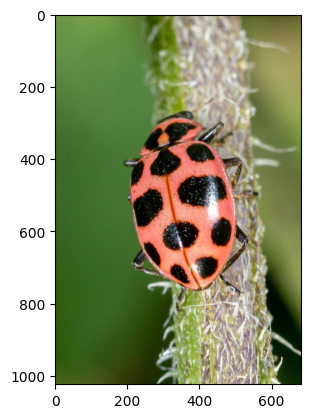

In [31]:
from skimage.io import imread
import os

data_path = r'../../data'
parent_path = os.path.join(data_path, 'ladybugs_SAM')
image_name = os.path.join(parent_path, '41108879_65181698.jpg')

img = imread(image_name)

plt.imshow(img)

### Call Yolo then SAM

1.  First we call Yolo to get bounding boxes
2.  Then we create a 'StackedLabels' object from the bounding boxes
3.  Then we use the 'StackedLabels' API to segment using 'MobileSAMV2'
4.  Then we order masks largest to smallest.
5.  Now a min projection will show small objects on top (because they have larger indexes. )

In [32]:
results = yolo_detecter.get_results(img, conf=conf, iou= iou, imgsz=imagesz, max_det=10000)
bbs=results[0].boxes.xyxy.cpu().numpy()
stacked_labels = StackedLabels.from_yolo_results(bbs, None, img)
segmented_stacked_labels = segment_from_stacked_labels(stacked_labels, "MobileSamV2")
segmented_stacked_labels.sort_largest_to_smallest()
labels = segmented_stacked_labels.make_2d_labels(type="min")


0: 1024x704 26 objects, 57.0ms
Speed: 4.1ms preprocess, 57.0ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)


VIT checkpoint loaded successfully


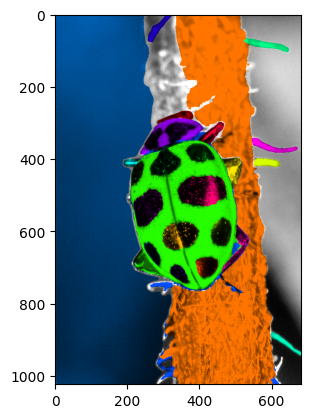

In [33]:
test = mask_overlay(img, labels)

plt.imshow(test, cmap=random_label_cmap())

## View in Napari

... With the ```napari_segment_everything``` widget.

In [34]:
import napari
from  napari_segment_everything import segment_everything

viewer = napari.Viewer()
segment_everything_widget=segment_everything.NapariSegmentEverything(viewer)
viewer.window.add_dock_widget(segment_everything_widget)
segment_everything_widget.load_project(segmented_stacked_labels.image, segmented_stacked_labels.mask_list)


area 740.0 255449.0
label_num 1 26
solidity 0.4784172661870504 0.9746682750301568
circularity 0.136122165105899 0.861142628998894
mean_intensity 20.925378326665506 178.02056202878683
10th_percentile_intensity 3.0 149.0
mean_hue 29.870610092695426 92.09416869831918
mean_saturation 37.81571733819619 214.5295492284336
predicted_iou 0.8793807625770569 0.9723882675170898
stability_score 0.891812264919281 0.9911127090454102


In [35]:
layer = viewer.layers['SAM 3D labels']
image_layer = viewer.layers['image']
layer.scale = [10, 1, 1]
layer.translate = [-10*len(segmented_stacked_labels.mask_list), 0, 0]